##Preprocessing

In [ ]:
pip install monai==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00


In [ ]:
pip install first

In [ ]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
pip install self_attention_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.3 MB/s eta 0:00:00


In [ ]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import numpy as np
import nibabel as nib
import torch
import first
import einops
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.networks.nets import UNet
from monai.networks.nets import SwinUNETR
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss, Dice, DiceFocalLoss
from monai.utils import first, set_determinism
from monai.transforms import Activations
from monai.inferers import sliding_window_inference
from torch.optim.lr_scheduler import ReduceLROnPlateau
from self_attention_cv import UNETR

In [ ]:
def prepare(in_dir, pixdim=(1.0, 1.0, 1.0), a_min=1000, a_max=1500, spatial_size=[128,128,128], cache=False):

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSeg", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSeg", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),


        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [ ]:
in_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan'
patient = prepare(in_dir)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

##Training

In [ ]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def calculate_iou(predicted, target):
    iouvalue = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True, jaccard=True)
    iou_value = 1-iouvalue(predicted,target).item()
    return iou_value


In [ ]:
def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1, device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    save_iou_train = []
    save_iou_test = []
    train_loader, test_loader = data_in

    # Initialize the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optim, mode='max', factor=0.1, patience=5, verbose=True)

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        epoch_iou_train = 0

        for batch_data in train_loader:
            train_step += 1
            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)

            train_loss = loss(outputs, label)

            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                  f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

            train_iou = calculate_iou(outputs, label)
            epoch_iou_train += train_iou
            print(f'Train_IoU: {train_iou:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')
        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        epoch_iou_train /= train_step
        print(f'Epoch_IoU: {epoch_iou_train:.4f}')
        save_iou_train.append(epoch_iou_train)
        np.save(os.path.join(model_dir, 'iou_train.npy'), save_iou_train)

        # Update the scheduler with the current epoch_metric_train
        scheduler.step(epoch_metric_train)

        if (epoch + 1) % test_interval == 0:
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0
                test_iou = 0
                epoch_iou_test = 0

                for test_data in test_loader:
                    test_step += 1
                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                    test_outputs = model(test_volume)

                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    test_iou = calculate_iou(test_outputs, test_label)
                    epoch_iou_test += test_iou

                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                epoch_iou_test /= test_step
                print(f'test_iou_epoch: {epoch_iou_test:.4f}')
                save_iou_test.append(epoch_iou_test)
                np.save(os.path.join(model_dir, 'iou_test.npy'), save_iou_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import annotations

import itertools
from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option, optional_import

rearrange, _ = optional_import("einops", name="rearrange")

__all__ = [
    "SwinUNETR",
    "window_partition",
    "window_reverse",
    "WindowAttention",
    "SwinTransformerBlock",
    "PatchMerging",
    "PatchMergingV2",
    "MERGING_MODE",
    "BasicLayer",
    "SwinTransformer",
]


class SwinUNETR(nn.Module):
    """
    Swin UNETR based on: "Hatamizadeh et al.,
    Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images
    <https://arxiv.org/abs/2201.01266>"
    """

    def __init__(
        self,
        img_size: Sequence[int] | int,
        in_channels: int,
        out_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        norm_name: tuple | str = "instance",
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            img_size: dimension of input image.
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            feature_size: dimension of network feature size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            norm_name: feature normalization type and arguments.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            dropout_path_rate: drop path rate.
            normalize: normalize output intermediate features in each stage.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: number of spatial dims.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beggining of each swin stage.

        Examples::

            # for 3D single channel input with size (96,96,96), 4-channel output and feature size of 48.
            >>> net = SwinUNETR(img_size=(96,96,96), in_channels=1, out_channels=4, feature_size=48)

            # for 3D 4-channel input with size (128,128,128), 3-channel output and (2,4,2,2) layers in each stage.
            >>> net = SwinUNETR(img_size=(128,128,128), in_channels=4, out_channels=3, depths=(2,4,2,2))

            # for 2D single channel input with size (96,96), 2-channel output and gradient checkpointing.
            >>> net = SwinUNETR(img_size=(96,96), in_channels=3, out_channels=2, use_checkpoint=True, spatial_dims=2)

        """

        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_size = ensure_tuple_rep(2, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)

        if spatial_dims not in (2, 3):
            raise ValueError("spatial dimension should be 2 or 3.")

        for m, p in zip(img_size, patch_size):
            for i in range(5):
                if m % np.power(p, i + 1) != 0:
                    raise ValueError("input image size (img_size) should be divisible by stage-wise image resolution.")

        if not (0 <= drop_rate <= 1):
            raise ValueError("dropout rate should be between 0 and 1.")

        if not (0 <= attn_drop_rate <= 1):
            raise ValueError("attention dropout rate should be between 0 and 1.")

        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("drop path rate should be between 0 and 1.")

        if feature_size % 12 != 0:
            raise ValueError("feature_size should be divisible by 12.")

        self.normalize = normalize

        self.swinViT = SwinTransformer(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_size,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
            use_v2=use_v2,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=2 * feature_size,
            out_channels=2 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * feature_size,
            out_channels=4 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder10 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=16 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)


    def load_from(self, weights):
        with torch.no_grad():
            self.swinViT.patch_embed.proj.weight.copy_(weights["state_dict"]["module.patch_embed.proj.weight"])
            self.swinViT.patch_embed.proj.bias.copy_(weights["state_dict"]["module.patch_embed.proj.bias"])
            for bname, block in self.swinViT.layers1[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers1")
            self.swinViT.layers1[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.reduction.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers2[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers2")
            self.swinViT.layers2[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.reduction.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers3[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers3")
            self.swinViT.layers3[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.reduction.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers4[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers4")
            self.swinViT.layers4[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.reduction.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.bias"]
            )

    def forward(self, x_in):
        hidden_states_out = self.swinViT(x_in, self.normalize)
        enc0 = self.encoder1(x_in)
        enc1 = self.encoder2(hidden_states_out[0])
        enc2 = self.encoder3(hidden_states_out[1])
        enc3 = self.encoder4(hidden_states_out[2])
        dec4 = self.encoder10(hidden_states_out[4])
        dec3 = self.decoder5(dec4, hidden_states_out[3])
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0, enc0)
        logits = self.out(out)
        return logits



def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows


def window_reverse(windows, window_size, dims):
    """window reverse operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        windows: windows tensor.
        window_size: local window size.
        dims: dimension values.
    """
    if len(dims) == 4:
        b, d, h, w = dims
        x = windows.view(
            b,
            d // window_size[0],
            h // window_size[1],
            w // window_size[2],
            window_size[0],
            window_size[1],
            window_size[2],
            -1,
        )
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(b, d, h, w, -1)

    elif len(dims) == 3:
        b, h, w = dims
        x = windows.view(b, h // window_size[0], w // window_size[1], window_size[0], window_size[1], -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


def get_window_size(x_size, window_size, shift_size=None):
    """Computing window size based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x_size: input size.
        window_size: local window size.
        shift_size: window shifting size.
    """

    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


class WindowAttention(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            qkv_bias: add a learnable bias to query, key, value.
            attn_drop: attention dropout rate.
            proj_drop: dropout rate of output.
        """

        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        mesh_args = torch.meshgrid.__kwdefaults__

        if len(self.window_size) == 3:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1),
                    num_heads,
                )
            )
            coords_d = torch.arange(self.window_size[0])
            coords_h = torch.arange(self.window_size[1])
            coords_w = torch.arange(self.window_size[2])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 2] += self.window_size[2] - 1
            relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        elif len(self.window_size) == 2:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
            )
            coords_h = torch.arange(self.window_size[0])
            coords_w = torch.arange(self.window_size[1])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1

        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        b, n, c = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone()[:n, :n].reshape(-1)  # type: ignore
        ].reshape(n, n, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn).to(v.dtype)
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer block based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        shift_size: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: str = "GELU",
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            shift_size: window shift size.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: stochastic depth rate.
            act_layer: activation layer.
            norm_layer: normalization layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(hidden_size=dim, mlp_dim=mlp_hidden_dim, act=act_layer, dropout_rate=drop, dropout_mode="swin")

    def forward_part1(self, x, mask_matrix):
        x_shape = x.size()
        x = self.norm1(x)
        if len(x_shape) == 5:
            b, d, h, w, c = x.shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            pad_l = pad_t = pad_d0 = 0
            pad_d1 = (window_size[0] - d % window_size[0]) % window_size[0]
            pad_b = (window_size[1] - h % window_size[1]) % window_size[1]
            pad_r = (window_size[2] - w % window_size[2]) % window_size[2]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
            _, dp, hp, wp, _ = x.shape
            dims = [b, dp, hp, wp]

        elif len(x_shape) == 4:
            b, h, w, c = x.shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            pad_l = pad_t = 0
            pad_b = (window_size[0] - h % window_size[0]) % window_size[0]
            pad_r = (window_size[1] - w % window_size[1]) % window_size[1]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
            _, hp, wp, _ = x.shape
            dims = [b, hp, wp]

        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None
        x_windows = window_partition(shifted_x, window_size)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        attn_windows = attn_windows.view(-1, *(window_size + (c,)))
        shifted_x = window_reverse(attn_windows, window_size, dims)
        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if len(x_shape) == 5:
            if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
                x = x[:, :d, :h, :w, :].contiguous()
        elif len(x_shape) == 4:
            if pad_r > 0 or pad_b > 0:
                x = x[:, :h, :w, :].contiguous()

        return x

    def forward_part2(self, x):
        return self.drop_path(self.mlp(self.norm2(x)))

    def load_from(self, weights, n_block, layer):
        root = f"module.{layer}.0.blocks.{n_block}."
        block_names = [
            "norm1.weight",
            "norm1.bias",
            "attn.relative_position_bias_table",
            "attn.relative_position_index",
            "attn.qkv.weight",
            "attn.qkv.bias",
            "attn.proj.weight",
            "attn.proj.bias",
            "norm2.weight",
            "norm2.bias",
            "mlp.fc1.weight",
            "mlp.fc1.bias",
            "mlp.fc2.weight",
            "mlp.fc2.bias",
        ]
        with torch.no_grad():
            self.norm1.weight.copy_(weights["state_dict"][root + block_names[0]])
            self.norm1.bias.copy_(weights["state_dict"][root + block_names[1]])
            self.attn.relative_position_bias_table.copy_(weights["state_dict"][root + block_names[2]])
            self.attn.relative_position_index.copy_(weights["state_dict"][root + block_names[3]])  # type: ignore
            self.attn.qkv.weight.copy_(weights["state_dict"][root + block_names[4]])
            self.attn.qkv.bias.copy_(weights["state_dict"][root + block_names[5]])
            self.attn.proj.weight.copy_(weights["state_dict"][root + block_names[6]])
            self.attn.proj.bias.copy_(weights["state_dict"][root + block_names[7]])
            self.norm2.weight.copy_(weights["state_dict"][root + block_names[8]])
            self.norm2.bias.copy_(weights["state_dict"][root + block_names[9]])
            self.mlp.linear1.weight.copy_(weights["state_dict"][root + block_names[10]])
            self.mlp.linear1.bias.copy_(weights["state_dict"][root + block_names[11]])
            self.mlp.linear2.weight.copy_(weights["state_dict"][root + block_names[12]])
            self.mlp.linear2.bias.copy_(weights["state_dict"][root + block_names[13]])

    def forward(self, x, mask_matrix):
        shortcut = x
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix)
        else:
            x = self.forward_part1(x, mask_matrix)
        x = shortcut + self.drop_path(x)
        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x)
        else:
            x = x + self.forward_part2(x)
        return x


class PatchMergingV2(nn.Module):
    """
    Patch merging layer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(self, dim: int, norm_layer: type[LayerNorm] = nn.LayerNorm, spatial_dims: int = 3) -> None:
        """
        Args:
            dim: number of feature channels.
            norm_layer: normalization layer.
            spatial_dims: number of spatial dims.
        """

        super().__init__()
        self.dim = dim
        if spatial_dims == 3:
            self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(8 * dim)
        elif spatial_dims == 2:
            self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(4 * dim)

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, d, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
            x = torch.cat(
                [x[:, i::2, j::2, k::2, :] for i, j, k in itertools.product(range(2), range(2), range(2))], -1
            )

        elif len(x_shape) == 4:
            b, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2))
            x = torch.cat([x[:, j::2, i::2, :] for i, j in itertools.product(range(2), range(2))], -1)

        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchMerging(PatchMergingV2):
    """The `PatchMerging` module previously defined in v0.9.0."""

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 4:
            return super().forward(x)
        if len(x_shape) != 5:
            raise ValueError(f"expecting 5D x, got {x.shape}.")
        b, d, h, w, c = x_shape
        pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 0::2, 1::2, :]
        x5 = x[:, 0::2, 1::2, 0::2, :]
        x6 = x[:, 0::2, 0::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)
        x = self.norm(x)
        x = self.reduction(x)
        return x


MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}


def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1

    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1

    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    return attn_mask


class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer in one stage based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: Sequence[int],
        drop_path: list,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        downsample: nn.Module | None = None,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            depth: number of layers in each stage.
            num_heads: number of attention heads.
            window_size: local window size.
            drop_path: stochastic depth rate.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            norm_layer: normalization layer.
            downsample: an optional downsampling layer at the end of the layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.no_shift = tuple(0 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=self.window_size,
                    shift_size=self.no_shift if (i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                    use_checkpoint=use_checkpoint,
                )
                for i in range(depth)
            ]
        )
        self.downsample = downsample
        if callable(self.downsample):
            self.downsample = downsample(dim=dim, norm_layer=norm_layer, spatial_dims=len(self.window_size))

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, c, d, h, w = x_shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c d h w -> b d h w c")
            dp = int(np.ceil(d / window_size[0])) * window_size[0]
            hp = int(np.ceil(h / window_size[1])) * window_size[1]
            wp = int(np.ceil(w / window_size[2])) * window_size[2]
            attn_mask = compute_mask([dp, hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, d, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b d h w c -> b c d h w")

        elif len(x_shape) == 4:
            b, c, h, w = x_shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c h w -> b h w c")
            hp = int(np.ceil(h / window_size[0])) * window_size[0]
            wp = int(np.ceil(w / window_size[1])) * window_size[1]
            attn_mask = compute_mask([hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b h w c -> b c h w")
        return x


class SwinTransformer(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            in_chans: dimension of input channels.
            embed_dim: number of linear projection output channels.
            window_size: local window size.
            patch_size: patch size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            drop_path_rate: stochastic depth rate.
            norm_layer: normalization layer.
            patch_norm: add normalization after patch embedding.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: spatial dimension.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beginning of each swin stage.
        """

        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.window_size = window_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(
            patch_size=self.patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # type: ignore
            spatial_dims=spatial_dims,
        )
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        self.use_v2 = use_v2
        self.layers1 = nn.ModuleList()
        self.layers2 = nn.ModuleList()
        self.layers3 = nn.ModuleList()
        self.layers4 = nn.ModuleList()
        if self.use_v2:
            self.layers1c = nn.ModuleList()
            self.layers2c = nn.ModuleList()
            self.layers3c = nn.ModuleList()
            self.layers4c = nn.ModuleList()
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=self.window_size,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                norm_layer=norm_layer,
                downsample=down_sample_mod,
                use_checkpoint=use_checkpoint,
            )
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            elif i_layer == 3:
                self.layers4.append(layer)
            if self.use_v2:
                layerc = UnetrBasicBlock(
                    spatial_dims=3,
                    in_channels=embed_dim * 2**i_layer,
                    out_channels=embed_dim * 2**i_layer,
                    kernel_size=3,
                    stride=1,
                    norm_name="instance",
                    res_block=True,
                )
                if i_layer == 0:
                    self.layers1c.append(layerc)
                elif i_layer == 1:
                    self.layers2c.append(layerc)
                elif i_layer == 2:
                    self.layers3c.append(layerc)
                elif i_layer == 3:
                    self.layers4c.append(layerc)

        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        if normalize:
            x_shape = x.size()
            if len(x_shape) == 5:
                n, ch, d, h, w = x_shape
                x = rearrange(x, "n c d h w -> n d h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n d h w c -> n c d h w")
            elif len(x_shape) == 4:
                n, ch, h, w = x_shape
                x = rearrange(x, "n c h w -> n h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n h w c -> n c h w")
        return x

    def forward(self, x, normalize=True):
        x0 = self.patch_embed(x)
        x0 = self.pos_drop(x0)
        x0_out = self.proj_out(x0, normalize)
        if self.use_v2:
            x0 = self.layers1c[0](x0.contiguous())
        x1 = self.layers1[0](x0.contiguous())
        x1_out = self.proj_out(x1, normalize)
        if self.use_v2:
            x1 = self.layers2c[0](x1.contiguous())
        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        if self.use_v2:
            x2 = self.layers3c[0](x2.contiguous())
        x3 = self.layers3[0](x2.contiguous())
        x3_out = self.proj_out(x3, normalize)
        if self.use_v2:
            x3 = self.layers4c[0](x3.contiguous())
        x4 = self.layers4[0](x3.contiguous())
        x4_out = self.proj_out(x4, normalize)
        return [x0_out, x1_out, x2_out, x3_out, x4_out]

In [ ]:
data_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/128 CT scan'
model_dir = '/content/drive/MyDrive/SMT 7/Internship-AIDA/NEW results 128 Swin UNETR'
data_in = prepare(data_dir, cache=False)

roi_size=(128, 128, 128)
device = torch.device("cuda:0")
model = SwinUNETR(img_size=tuple(roi_size),
                  in_channels=1,
                  out_channels=2,
                  drop_rate=0.1).to(device)

#loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
loss_function = DiceFocalLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [ ]:
train(model, data_in, loss_function, optimizer, 500, model_dir)

Streaming output truncated to the last 5000 lines.
Train_IoU: 0.9855
6/16, Train_loss: 0.0099
Train_dice: 0.9929
Train_IoU: 0.9860
7/16, Train_loss: 0.0111
Train_dice: 0.9924
Train_IoU: 0.9850
8/16, Train_loss: 0.0082
Train_dice: 0.9932
Train_IoU: 0.9866
9/16, Train_loss: 0.0086
Train_dice: 0.9929
Train_IoU: 0.9859
10/16, Train_loss: 0.0086
Train_dice: 0.9930
Train_IoU: 0.9861
11/16, Train_loss: 0.0108
Train_dice: 0.9922
Train_IoU: 0.9846
12/16, Train_loss: 0.0090
Train_dice: 0.9928
Train_IoU: 0.9858
13/16, Train_loss: 0.0093
Train_dice: 0.9921
Train_IoU: 0.9843
14/16, Train_loss: 0.0101
Train_dice: 0.9929
Train_IoU: 0.9859
15/16, Train_loss: 0.0112
Train_dice: 0.9920
Train_IoU: 0.9841
16/16, Train_loss: 0.0121
Train_dice: 0.9910
Train_IoU: 0.9823
--------------------
Epoch_loss: 0.0100
Epoch_metric: 0.9924
Epoch_IoU: 0.9850
test_loss_epoch: 0.0344
test_dice_epoch: 0.9786
test_iou_epoch: 0.9587
current epoch: 416 current mean dice: 0.9750
best mean dice: 0.9793 at epoch: 118
----------

##Testing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))
train_iou = np.load(os.path.join(model_dir, 'iou_train.npy'))
test_iou = np.load(os.path.join(model_dir, 'iou_test.npy'))

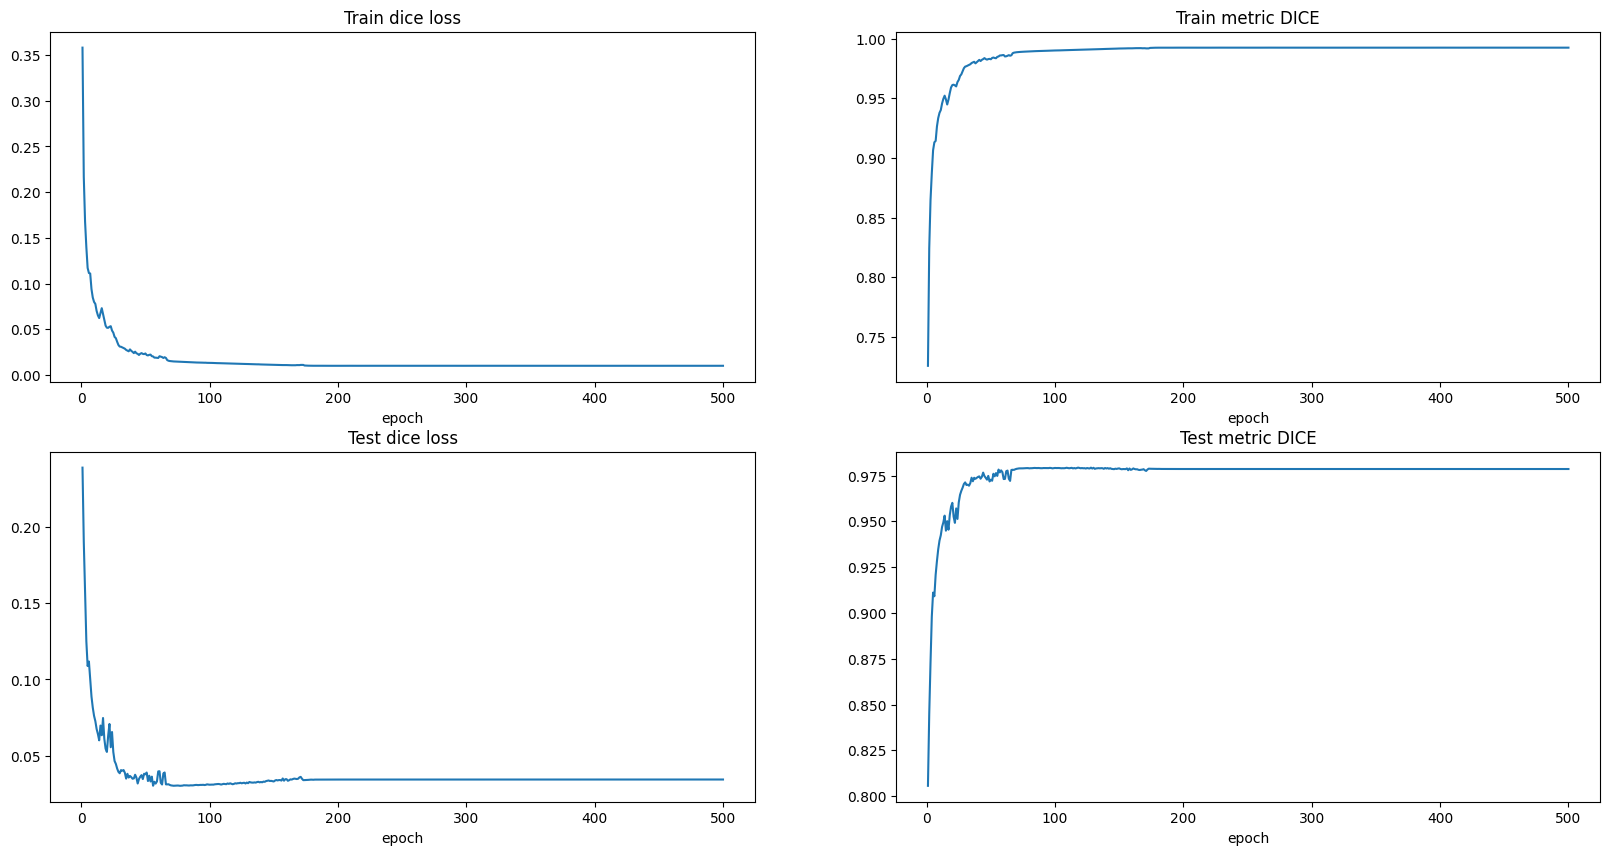

In [ ]:
plt.figure("Evaluate", (20, 10))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

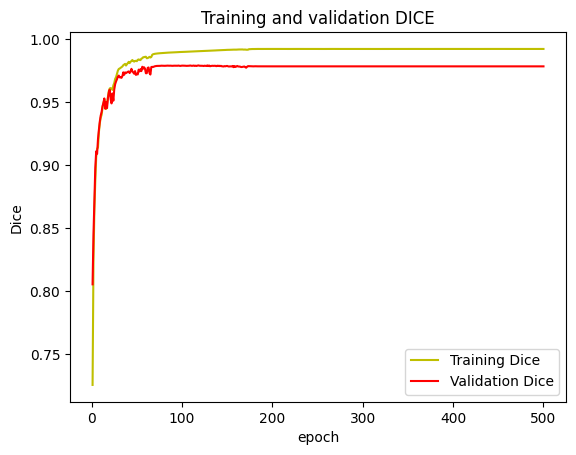

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot training and validation dice
plt.title("Training and validation DICE")
dice = train_metric
val_dice = test_metric
epochs = [i + 1 for i in range(len(train_metric))]
plt.plot(epochs, dice, 'y', label='Training Dice')
plt.plot(epochs, val_dice, 'r', label='Validation Dice')
plt.xlabel("epoch")
plt.ylabel("Dice")
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

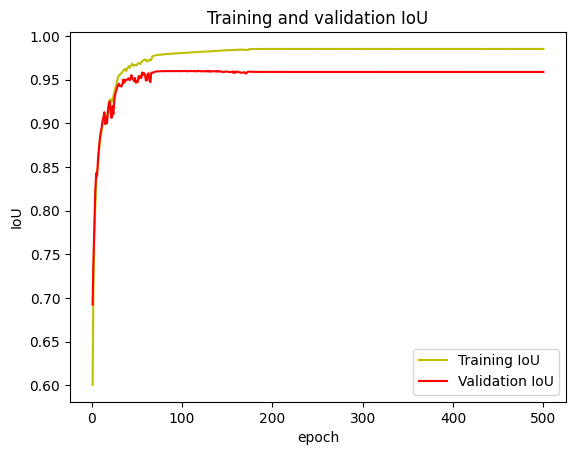

In [ ]:
# Plot training and validation IOU
plt.title("Training and validation IoU")
iou = train_iou
val_iou = test_iou
epochs = [i + 1 for i in range(len(train_iou))]
plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.xlabel("epoch")
plt.ylabel("IoU")
plt.legend()
plt.show()

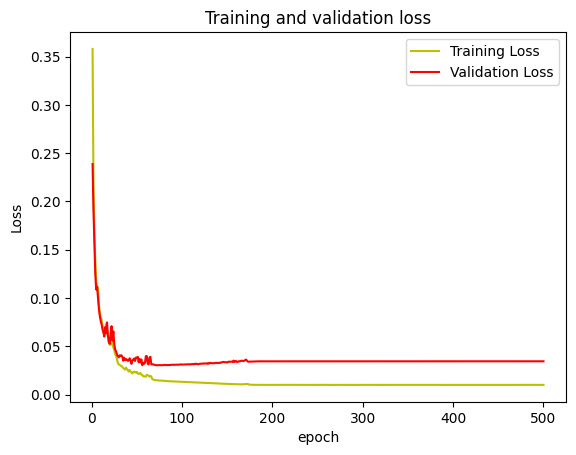

In [ ]:
# Plot training and validation dice loss
plt.title("Training and validation loss")
loss = train_loss
val_loss = test_loss
epochs = [i + 1 for i in range(len(train_loss))]
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
in_dir = data_dir
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSeg", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSeg", "*.nii.gz")))

#path_val_volumes = sorted(glob(os.path.join(in_dir, "ValVolumes", "*.nii.gz")))
#path_val_segmentation = sorted(glob(os.path.join(in_dir, "ValSeg", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[3:4]
#val_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_val_volumes, path_val_segmentation)]
#val_files = val_files[0:4]

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.0,1.0,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=1000, a_max=1500,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,128]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [ ]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

#val_ds = Dataset(data=val_files, transform=test_transforms)
#val_loader = DataLoader(val_ds, batch_size=1)

In [ ]:
roi_size=(128,128,128)
device = torch.device("cuda:0")
model = SwinUNETR(img_size=tuple(roi_size),
                  in_channels=1,
                  out_channels=2,
                  drop_rate=0.1).to(device)

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.1, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear2): Linear(in_features=

In [ ]:
pip install torchsummary

In [ ]:
from torchsummary import summary

# Assuming model is already defined
summary(model, input_size=(1, roi_size[0], roi_size[1], roi_size[2]))

In [ ]:
pip install torchinfo

In [ ]:
import torch
from torchinfo import summary

# Create a dummy input with 1 channel for PatchEmbed
dummy_input = torch.randn((1, 1, roi_size[0], roi_size[1], roi_size[2])).to("cuda")

# Use torchinfo to print the summary
summary(model, input_data=dummy_input)


Layer (type:depth-idx)                                  Output Shape              Param #
SwinUNETR                                               [1, 2, 128, 128, 128]     --
├─SwinTransformer: 1-1                                  [1, 24, 64, 64, 64]       --
│    └─PatchEmbed: 2-1                                  [1, 24, 64, 64, 64]       --
│    │    └─Conv3d: 3-1                                 [1, 24, 64, 64, 64]       216
│    └─Dropout: 2-2                                     [1, 24, 64, 64, 64]       --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─BasicLayer: 3-2                             [1, 48, 32, 32, 32]       37,230
│    └─ModuleList: 2-4                                  --                        --
│    │    └─BasicLayer: 3-3                             [1, 96, 16, 16, 16]       120,540
│    └─ModuleList: 2-5                                  --                        --
│    │    └─BasicLayer: 3-4                       

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.inferers import sliding_window_inference

In [ ]:
sw_batch_size = 4
roi_size = (128, 128, 128)
with torch.no_grad():
    test_patient = first(test_loader) #
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    for i in range(128):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i], cmap='gray')
        plt.show()

In [ ]:
print("Volume shape:", t_volume.shape)

Volume shape: torch.Size([1, 1, 128, 128, 128])


In [ ]:
import torch
import time
import matplotlib.pyplot as plt
from monai.transforms import Activations
from monai.inferers import sliding_window_inference


sw_batch_size = 4
roi_size = (128, 128, 128)

# Get a sample from the test_loader
with torch.no_grad():
    test_patient = next(iter(test_loader))
    t_volume = test_patient['vol'].to(device)

    # Measure inference time
    start_time = time.time()

    # Inference
    test_outputs = sliding_window_inference(t_volume, roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    # Measure elapsed time
    elapsed_time = time.time() - start_time
    print(f"Inference time: {elapsed_time} seconds")

    # Visualization
    for i in range(128):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i], cmap='gray')
        plt.show()

In [ ]:
# Load the best model checkpoint
best_model_path = os.path.join(model_dir, "best_metric_model.pth")
best_model = model.to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

def evaluate(model, dataloader, loss_function, device=torch.device("cuda:0")):
    model.eval()
    total_loss = 0.0
    total_metric = 0.0
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch_data in dataloader:
            inputs = batch_data["vol"].to(device)
            labels = batch_data["seg"].to(device)
            labels = labels != 0  # Assuming binary segmentation

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            total_loss += loss.item()

            # Compute your evaluation metric (e.g., dice coefficient)
            metric = dice_metric(outputs, labels)
            total_metric += metric

            # Compute IoU
            iou = calculate_iou(outputs, labels)
            total_iou += iou

            total_samples += inputs.size(0)

    average_loss = total_loss / total_samples
    average_metric = total_metric / total_samples
    average_iou = total_iou / total_samples

    return average_loss, average_metric, average_iou

# Evaluate the best model on your test data
final_test_loss, final_test_metric, final_test_iou = evaluate(best_model, test_loader, loss_function, device)

# Print the final metrics
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Dice: {final_test_metric:.4f}")
print(f"Final Test IoU: {final_test_iou:.4f}")

Final Test Loss: 0.0313
Final Test Dice: 0.9793
Final Test IoU: 0.9601


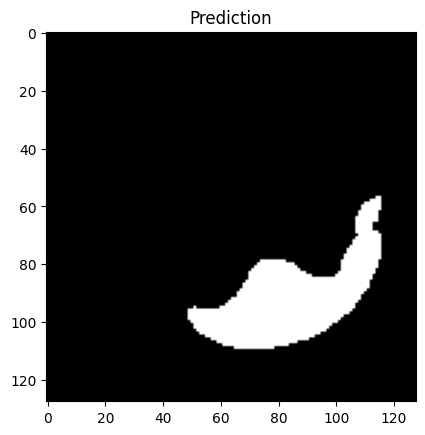

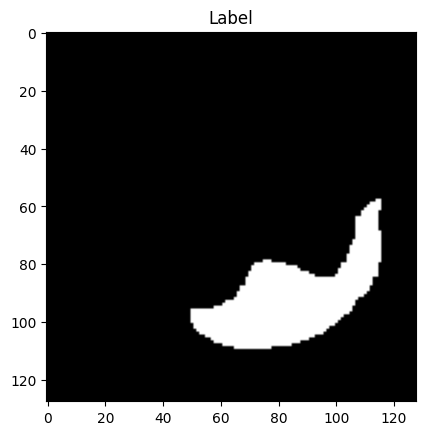

In [ ]:
import nibabel as nib
from torch.cuda.amp import autocast

sw_batch_size = 4
roi_size = (128, 128, 128)

with torch.no_grad(), autocast():
    test_patient = first(test_loader) #
    t_volume = test_patient['vol']
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.5

    # Convert boolean array to integer array for prediction
    prediction_array = test_outputs[0, 1].detach().cpu().numpy().astype(np.uint8)

    # Convert original mask values to binary mask (0 or 1)
    label_array = (test_patient['seg'][0, 0].detach().cpu().numpy() > 0).astype(np.uint8)

    # Save the prediction and label as Nifti
    output_nifti_pred = nib.Nifti1Image(prediction_array, affine=np.eye(4))
    output_nifti_label = nib.Nifti1Image(label_array, affine=np.eye(4))

    nib.save(output_nifti_pred, 'NEW_FIX_SWIN29PREDICT.nii.gz')
    #nib.save(output_nifti_label, 'label_19.nii.gz')

    import matplotlib.pyplot as plt

    # Example visualization for prediction
    plt.imshow(prediction_array[:, :, 80], cmap='gray')
    plt.title('Prediction')
    plt.show()

    # Example visualization for label with 'binary' colormap
    plt.imshow(label_array[:, :, 80], cmap='gray')
    plt.title('Label')
    plt.show()
